# Digits classifier

Let's build a model that is able to recognize digits 3 and 7.

In [948]:
# loading and setting up dependencies
import fastbook

fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *
from matplotlib import pyplot as plt
from torch.nn import functional as F

## Importing the dataset

In [949]:
# import MNIST sample that only contains 3s and 7s
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

As you can see from the previous output, this dataset is organized into separate folders for training and validation sets.

In [950]:
# let's see what's inside the training set
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

We are confirming here that the training sample contains 7's and 3's only. These are our _labels_. Let's zoom in a little more.

In [951]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

## Images as array of numbers, e.g. tensors

In [952]:
# let's look at one image
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [953]:
# viewing the numbers that make up that image as a `NumPy` array
array(im3)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253, 253, 233,   0

In [954]:
# selecting a subarray from rows 4 to 10 (not included) and columns 4 to 10 (not included)
# `numpy` indexes from top to bottom and left to right
array(im3)[4:10,4:10] 

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [955]:
# now let's do the same thing with a `pytorch` tensor
im3_t = tensor(im3)

In [956]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [957]:
# let's make a data frame out of the three image specimen tensor,
# we'll only select the top part of the image
df = pd.DataFrame(im3_t[4:15,4:22])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [958]:
# now let's color code the values
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## getting on with our baseline model

The _baseline_ of our classifier will be very simple, as it should be:

- find the average pixel value for every pixel of the 3s
- find the average pixel value for every pixel of the 7s

This gives us group averages that we may call "ideal" 3s and 7s. We would first classify a digit as a 3 if the average pixel value of the digit is closer to the ideal 3 than to the ideal 7, and vice versa.

In [959]:
# create lists of tensors containing all 3s and 7s stacked together
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

<Axes: >

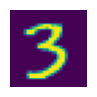

In [960]:
# Jupyter ships with a function called `show_image` that knows how to render a tensor as an image
show_image(three_tensors[1])

## rank-3 tensors

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. 

To do this we first combine all the images in this list into a single three-dimensional tensor. 

The most common way to describe such a tensor is to call it a _rank-3 tensor_.

See an example of what that might look like below:

![rank-3 tensor.png](./rank-3-tensor.png)

A rank-3 tensor is essentially a cube of numbers.

To index a number of that tensor, you would need:

- the layer
- the row
- the column

### how did we conclude that we needed a rank-3 tensor?

- Each image is a 2d matrix of pixels (rows and columns, e.g. a _rank-2 tensor_)
- Each element in the matrix corresponds to a pixel intensity (a scalar value, e.g. a _rank-1 tensor_)
- To ease computing of the average of each pixel intensity over all images, you would stack each of these matrices on top of each other: there you have it, a _rank-3 tensor_

In [961]:
# let's our images and cast our stacked tensors as float tensors for further computation
# we also normalise our pixel values to be between 0 and 1 by dividing by 255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

# a _shape_ tells us the length of each axis of a tensor
stacked_threes.shape

torch.Size([6131, 28, 28])

The previous output says to us: "we have 6131 images, each of size 28x28 pixels". 

We can define the _shape_ as **the size of each axis in a tensor**.

As you may have noticed, we have also normalized the values of the pixels. We want all pixels to be between 0 and 1. By ensuring that all values are of similar scale, we improve the accuracy of our model.

In [962]:
# the _length_ of a tensor's shape is its _rank_
len(stacked_threes.shape)

3

In [963]:
# you could also get the rank of a tensor like so
stacked_threes.ndim

3

The _dimension_ 0 of our rank-3 tensor is the number of images.

Here is how you would compute the average pixel intensity for each pixel position:

<Axes: >

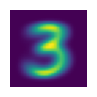

In [964]:
ideal3 = stacked_threes.mean(0)
show_image(ideal3)

<Axes: >

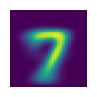

In [965]:
# let's do the same thing for the 7s
ideal7 = stacked_sevens.mean(0)
show_image(ideal7)

## Test the baseline model

Now that we have an idea of what our ideal 3 and 7 look like, we can try to classify our images. To test our baseline, we would pick an arbitrary number from the dataset and measure its distance from its _ideal_ representation.

<Axes: >

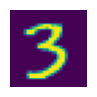

In [966]:
# here is our sample number for our test
a_3 = stacked_threes[1]
show_image(a_3)

To calculate the distance from the baseline `3`, we can't just add up the differences in intensity between each of the pixels of both images. It is so because some differences would cancel out (light vs dark pixels), and that would be misleading as very different pixels could have a value of zero, which would mean "no difference from the ideal digit representation".

There are two main ways data scientists measure distance in this context:

- take the mean absolute value of differences: this is called _mean absolute difference_ or _L1 norm_
- take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring): this is called _root mean squared error_ or _L2 norm_

In [967]:
# let's try the `L1` norm
dist3_l1 = (a_3 - ideal3).abs().mean()

dist3_l1

tensor(0.1114)

In [968]:
# let's try the `L2` norm now
dist3_l2 = ((a_3 - ideal3)**2).mean().sqrt()

dist3_l2

tensor(0.2021)

In [969]:
# let's check if our arbitrary number is a 3 or a 7 using both methods

# `L1` norm
dist7_l1 = (a_3 - ideal7).abs().mean()
dist7_l1

tensor(0.1586)

In [970]:
# we'll use the `L2` norm
dist7_l2 = ((a_3 - ideal7)**2).mean().sqrt()
dist7_l2

tensor(0.3021)

From the little experiment we've just run, we can see that our baseline model predicts right in this particular case, as both results are greater for a 7 than they would have been for a 3.

We could have done the same thing with `PyTorch`, which provides loss functions (among many other things), as shown below:

In [971]:
dist7_l1_torch = F.l1_loss(a_3.float(), ideal7)
dist7_l1_torch

tensor(0.1586)

In [972]:
dist7_l2_torch = F.mse_loss(a_3, ideal7).sqrt()
dist7_l2_torch

tensor(0.3021)

### L1 vs L2 norms

The main difference between L1 norm and MSE is that the latter will penalize bigger mistakes more heavily than the former, which may be more lenient with small mistakes.

## Defining a metric for our baseline model

A metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is.

In practice, _accuracy_ is a common metric for classification models.

- The _error rate_ in deep learning refers to the difference between the predicted output and the actual output of a neural network. It is a measure of how well the network is performing on a given task. In this context, _accuracy_ can be defined as `1.0 - error rate`.

A metric is always calculated over a _validation_ set.

To get a validation set, we need to remove some of the data of the training set entirely, so it's not seen by the model at all during training.

In [973]:
# let's create tensors for 3s and 7s using the MNIST validation set
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

# here we divided both tensors by 255 to normalize the pixel values between 0 and 1
# x images of size 28x28 pixels
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [974]:
# now let's write the function that will give use the MSE loss for a given image
def mnist_mse_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_mse_distance(a_3, ideal3)


tensor(0.1114)

### why `mean((-1,-2))`

The `mean` function in `PyTorch` can take a tuple of axes to take the mean of. 
In this case, we want to take the mean over the last two dimensions (in this case, the horizontal and vertical dimensions of an image).

The tuple `(-1,-2)` represents a range of axes.

This effectively allows us to make batch calculations on rank-3 tensors, as you will see in the example below.

In [975]:
# applying the same calculation for every image in our validation set
valid_3_dist = mnist_mse_distance(valid_3_tens, ideal3)
valid_3_dist, valid_3_dist.shape

# for every image, we averaged the intensity of all pixels in that image;
# we are left with a rank-1 tensor of a thousand numbers

(tensor([0.1463, 0.1526, 0.1214,  ..., 0.1360, 0.1326, 0.1422]),
 torch.Size([1010]))

`PyTorch` is so versatile it didn't even complain about shapes not matching and calculated the distance for each image instead !

This is made possible because `PyTorch` uses _broadcasting_ under the hood: e.g. the ability expand a lower rank tensor to have the same size as a higher rank input tensor during a calculation. This is why this type of operation is possible:

```python
tensor([1,2,3]) + tensor(1) # tensor([2,3,4])
```

When applying the `abs()` function on a tensor, you get back a matrix of absolute values.

Now let's continue with the function that determines if the number is a `3` or a `7`:

In [976]:
def is_3(x): return mnist_mse_distance(x,ideal3) < mnist_mse_distance(x,ideal7)

# let's test the function
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [977]:
# let's do the same thing at scale
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [978]:
# again but as floats
is_3(valid_3_tens).float()

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [979]:
# get the mean of correct predictions
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_3s

tensor(0.9168)

In [980]:
# let's do the above steps for 7s
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()
accuracy_7s

# we use the inverse here with `1 - is_3` because we want to know how many 7s we correctly identified (OR logic)

tensor(0.9854)

We can conclude from the above that we have a pretty good baseline for 2 numbers !

However, we are limited by the fact that we need to classify more than 2 numbers. This is where _Stochastic Gradient Descent_ (SGD) comes in.

## Introducing SGD

In our pixels similarity approach, we don't have any kind of weight assignment, or any way of improving our classifier based on testing the effectiveness of a weight assignment.

### A little aparté on weight assignment

A neural network is a mathematical function that is extremely flexible and that depends on its weights. Neural networks are powerful tools because they can solve a very wide array of problems just by finding the right weights.

Weights in an AI model are numerical values that define how strongly given inputs to a node or neuron influence its output, in other words, they are the _parameters_ that are learned during the training process.

Using neural networks gives the operator enough flexibility to focus his efforts on training the model, e.g. finding good weights assignments.

Weights are just variables, and a weight assignment is a particular choice of values for those variables. 

The program's inputs are values that it processes in order to produce its results, for instance, taking image pixels as inputs and returning the classification "dog" as a result. The program's weight assignments are other values that define how the program will operate.

A traditional program takes input and outputs results, whereas a machine learning program takes inputs and weights to output its results. Another difference is that the _program_ is a set of conditionals, loops, etc. whereas the _model_ is a mathematical function that minimizes errors to improve its accuracy. This function:
  - takes the inputs
  - multiplies them by a set of weights (nowaydays called `parameters`)
  - adds them up
  - redoes this process
  - once it's done, it takes all the negative numbers and replaces them with 0s
  - it then takes these inputs to a next _layer_ and redoes the whole process

This is how a deep learning model works, in contrast of a more classic program, which does not have weights.

Adjusting the weights here should is done with the goal of maximizing the model's performance. This adjustment can be done automatically.

As you can see, we also differentiate `results` from `performance`. For instance, the results can be the classification of an image, and the performance can be the accuracy of the classification.

The _loss_ is what is used to provide a better set of weights to the model, e.g. the model should aim at making the loss smaller

At some point, we can decide that a model is trained, that is we've chosen our favorite weight assignment; you will generally include the weights as part of the model at the end of this process. You can also note that a trained model can be treated like any other computer program when the training is over, this leverages powerful APIs. Another thing to note: once the model is trained, predicting (_inference_) is faster than training.  

Weight assignment in deep learning is like giving each input a score that affects how much it influences the output. For example, if you have a neural network that predicts the price of a house based on its size and location, you might give more weight to the size than the location, because size is more important for the price. The weights are usually random numbers at first, but they change as the network learns from the data. The way you choose the initial weights can affect how well the network learns and performs.

One way to choose the initial weights is to use some rules based on the type of function that each node uses to calculate its output. For example, some functions are like switches that turn on or off depending on the input, while others are like curves that smoothly change from low to high. Different rules work better for different functions, so you have to match them accordingly.

_Stochastic gradient descent_ is a technique used to update the weights of a neural network in order to make it improve at any given task. Its power resides in the fact that it provides a way of finding weight values automatically.

## Using another approach to classify digits: a linear model

Now, back to our problem.

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one.

For instance, pixels toward the bottom right are not very likely to activate neurons for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. 

This can be represented as a function with a set of weight values for each possible category, for instance the probability of being the number 8 =>

```python
def pr_eight(image_vector, weights_vector): return (image_vector * weights_vector).sum()
```

Here, the image represented as a vector is basically "all the rows stacked up end to end on a single long line". With this kind of function, we just need some way to update the weights to make them better and better at distinguishing between digits: we want to find the specific values for the weights that cause the result of our function to be high for images that are actually 8s, and low for images that are not. Searching for the best weights is a way of searching for the best function that recognizes 8s.

These are the steps that will turn our function into a machine learning classifier:

1. _Initialize_ the weights with random values
2. For each image, use these weights to predict whether it appears to be a 3 or a 7
3. Based on these predictions, calculate how good the model is (its _loss_)
4. Calculate the _gradient_, which measures for each weight, how changing that weight would change the loss; the gradients will tell us how much we have to change each weight to make our model better
5. _Step_ (that is, _change_) all the weights based on the previous calculation
    - A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating gradients. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
6. Go back to the step 2, and repeat the process
7. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer). Generally, you would want to stop the training process when the model stops improving or gets worse

These relatively simple steps are the basis for nearly all deep learning models.

Derivatives are a way of finding **the instantaneous rate of change** or **the slope** of a function at any given point. A derivative in calculus is a measure of how a function changes as its input changes. It's like the speedometer of a car; it tells you how fast you're going at any point in time. Derivatives calculate the change of a function, not it's value.

For example, if `f'(2) = 4`; this means several things:

- at `x = 2` the slope of the function `f(x)` is `4`
- we can interpret that any small change in `x` around `2` will increase `f(x)` 4 times as fast

When we know how a function changes, we know what we need to make its value smaller.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative of these weights we won't get back one number, but rather lots of them: a _gradient_ for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

Thankfully, `PyTorch` can automatically compute the derivative of nearly any function!

### The notion of _learning rate_

The _learning rate_ is the number by which you multiply the gradients in a gradients descent.

Deciding how to change our weights based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything.

Deciding which learning rate to use is a trial and error process. If you make it too big, your model will diverge, which means it will get worse and worse. But if you make it too small, the model will eventually improve, but it will take forever to converge.

The _learning rate_ is a hyperparameter: it controls how much the program adjusts its parameters in response to the feedback it gets. To understand with an analogy:
  - imagine a robot trying to learn how to walk
  - the learning rate would be the size of the steps the robot takes
  - if the steps are too wide, the robot will fall (overcorrecting)
  - if the steps are too small, the robot will take a long time to learn and hardly make any progress (undercorrecting)

Here is a visual representation of an undercorrecting model:

![undercorrecting model](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/chapter2_small.svg)

And here are some overcorrecting models examples:

![overcorrecting model](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff/images/chapter2_div.svg)

![overcorrecting model](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/chapter2_bouncy.svg)

... as you can see, the first one makes steps that are too big, resulting in a lousy performance, and the other bounces back and forth because of a step that may be a little too high, this would cause training to be very slow.

Adjusting the weights of our model can be then expressed as simply as:

```python	
weights -= gradient * lr
```

This is what _stepping the weights_ actually means.

We use a substraction here to allow for:

- in case the slope is positive, the weight to be decreased
- in case the slope is negative, the weight to be increased

Remember: our ultimate goal is to minimize the loss.

### SGD summary

Let's summarize a few points here:

- The weights of a model can be random (training a model from scratch) or they can come from a pre trained model (transfer learning).
- If you train a model from scratch, the first outputs you'll get will probably be pretty bad, because your weights are random.
- Also, in case of a pretrained model, the first outputs won't probably be what you want, because the model was trained for a different task. So, the model will need to _learn_ better weights.
- To measure the performance of a model, you compare the outputs the model gives you with the targets (the true labels), using a loss function.
- We want the output of the loss function to be as low as possible by improving the weights of the model.
- For improving the model, you'd want to set aside a few data items that you don't train the model on, called the _validation set_. This is the set that will be used to measure performance.
- Figuring out how to change the loss to make it better heavily relies on Calculus and gradients. This is made easy with tools like `PyTorch` 😎.
- At each pass of the iterative process that makes the weights better, we use the magnitude of each gradient to tell us how big a step is to take into a better direction. We multiply the gradients by a number called the _learning rate_ to decide each step size.
- When the loss does not get any better, we say that the model has _converged_ and we stop the training.

Alright, we are ready to apply this to the MNIST dataset now !



## Defining traingin and validation sets + parameters

For our digits classifier issue to solve, we already have independent variables (x-axis): these are the images themselves. This means we can put together our training dataset.

Let's concatenate all of them into a single tensor.

To do this, we'll need to go from a rank-3 tensor of images stacked together to a list of vectors (rank-2 tensor). This can be done using the `view` method of `PyTorch` tensors, as it changes the shape of a tensor without changing its contents.

In [981]:
# `torch.cat` concatenates tensors along the first dimension;
# then `view` reshapes the concatenated tensor into a rank-2 tensor,
# this new tensor has 28*28 columns and a number of rows equal to the number of images in the 2 original tensors;
# a 28*28 image is flattened into a 784-element vector
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [982]:
# let's label each image
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

The line of code above:

- concatenates 2 tensors of length `len(threes)` and `len(sevens)` respectively
- the first elements of this new tensor (`len(threes)`) are set to 0
- the last elements of this new tensor (`len(sevens)`) are set to 1
- calling `unsqueeze` on a tensor adds an extra dimension to it
- we add one extra dimension to match the shape of the images tensor that will be fed to the model
- the resulting tensor has a shape of `(n, 1)`, where `n` is the number of images in the dataset

In [983]:
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A `Dataset` in `PyTorch` is an abstract class that represents a collection of data samples.

When indexed, a `Dataset` is required to return a tuple of `(x,y)`, where `x` is the input data and `y` is the label.

A `Dataset` in `PyTorch` is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality. 

The `zip` function in Python takes two or more iterables and returns a zip object. The zip object is an iterator that produces tuples of corresponding elements from the iterables.

```python
list(zip([1, 2, 3], [4, 5, 6]))
# [(1, 4), (2, 5), (3, 6)]
```

As you can see, each tuple contains the corresponding elements from the 2 lists.

This is how we are going to use it to create our `Dataset` of images and labels.

In [984]:
dataset = list(zip(train_x,train_y))

# taking a look at the first element of the dataset,
# here, `y` represents the label of the image
x,y = dataset[0] 
x.shape,y

(torch.Size([784]), tensor([1]))

In [985]:
# now, let's put together our validation set
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
validation_set = list(zip(valid_x,valid_y))

In [986]:
# let's initialize our weights for every pixel with random values

# this function returns a tensor of size `size` filled with random values from a normal distribution with a standard deviation of `std`
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
# print a sample of our weights
weights[:5]

tensor([[-0.0263],
        [ 1.1391],
        [ 1.5193],
        [ 0.2975],
        [-0.4530]], grad_fn=<SliceBackward0>)

If the goal is to multiply each pixel of the images by a weight value, we should take into account the fact that some pixels will have a value of `0`.

This means that the function `weights * pixels` won't be flexible enough for our purpose since it can sometimes result in a value of `0` even if the weight is not `0`. In that case the y-intercept for this weight would be 0 and that's not we want.

Now, since the equation of a straight line is `y = wx + b`, we can add a constant `b` to our function to make it more flexible. This is called a _bias_.

Together, the _weights_ and the _bias_ are called the _parameters_ of the model.

In [987]:
bias = init_params(1)

# we are now able to calculate a prediction for an image,
# this is a simple implementation of a linear regression model;
# `weights.T` means "taking the transpose of the weights tensor",
# this is done because we want to multiply the weights by the pixels of the image,
# so we turn the `weights` matrix rows into columns and vice versa
(train_x[0]*weights.T).sum() + bias

tensor([0.1631], grad_fn=<AddBackward0>)

While we could use a Python for loop to calculate the prediction for each image, that would be very slow. Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.

In this case, there's an extremely convenient mathematical operation that calculates `w*x` for every row of a matrix: matrix multiplication.

In Python, matrix multiplication is represented with the `@` operator. Let's try it:

In [988]:
weights.shape

torch.Size([784, 1])

In [989]:
train_x.shape

torch.Size([12396, 784])

In [990]:
def multiply_data_by_params_model(independent_variables): return independent_variables@weights + bias
preds = multiply_data_by_params_model(train_x)
preds

tensor([[  0.1631],
        [ 12.1977],
        [ -0.9130],
        ...,
        [ -7.2611],
        [-26.5065],
        [-16.8774]], grad_fn=<AddBackward0>)

The equation `batch @ weights + bias` is a fundamental equation of any neural network.

## checking our model's accuracy

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.0, since a 3 is a one and a 7 is a 0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [991]:

corrects = (preds > 0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [992]:
# our accuracy would be ...
corrects.float().mean().item()

0.7566956877708435

## Choosing a loss function

As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some loss function that represents how good our model is. That is because the gradients are a measure of how the loss function changes with small tweaks to the weights. So, we need to choose a loss function.

A very small change of a weight won't influence the overall accuracy of the model, so we can exclude accuracy as our loss function.

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

The loss function receives not the images themselves, but the predictions from the model. Let's make one argument, `prds`, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another argument, `trgts`, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

Let's try this:

In [993]:
# measure how distant each prediction is from 1 if it should be 1, 
# and how distant it is from 0 if it should be 0, 
# and then take the mean of all those distances
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

The function above will return a lower number when:

- predictions are more accurate
- accurate predictions are more confident
- inaccurate predictions are less confident

One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that: the _sigmoid_ function.

This function always returns a value between 0 and 1. It is important in Deep Learning, as we deal with a lot of normalized data. It takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients.

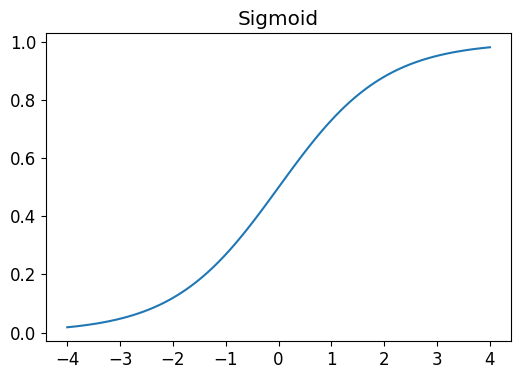

In [994]:
# plotting the sigmoid function
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [995]:
# let's update the `mnist_loss` function to use the sigmoid function
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

## Putting our linear modal together

In [996]:
# initialize our parameters
weights = init_params((28*28,1))
bias = init_params(1)

# creating a data loader that will return batches of a given size shuffled for every epoch
training_data_loader = DataLoader(dataset, batch_size=256)
x,y = first(training_data_loader)
x.shape,y.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [997]:
# creating a data loader for the validation set
validation_data_loader = DataLoader(validation_set, batch_size=256)

In [998]:
# let's define a few functions that will help us calculate the gradients and update the weights and biases

# let's also write a function that calculates accuracy for each batch
def batch_accuracy(independent_variables, dependent_variables):
    preds = independent_variables.sigmoid()
    correct = (preds > 0.5) == dependent_variables
    return correct.float().mean()

# let's put this logic into a function:
#  - making predictions
#  - calculating the loss
#  - calculating the gradients
def calc_grad(independent_variables, dependent_variables, model):
    preds = model(independent_variables)
    loss = mnist_loss(preds, dependent_variables)
    # The `backward` function actually adds the gradients of `loss` to any gradients that are currently stored.
    loss.backward()

# we need to update the weights and biases based on the gradient and learning rate
def train_epoch(model, lr, params):
    for independent_variables, dependent_variables in training_data_loader:
        calc_grad(independent_variables, dependent_variables, model)
        for p in params:
            p.data -= p.grad*lr
            # we have to tell `PyTorch` to not store the gradients for this step,
            # otherwise they would accumulate and things could get very confusing
            p.grad.zero_()

# let's write a validation function,
# this function `validate_epoch` takes a PyTorch model as input and evaluates its accuracy on a validation dataset.
# It does so by iterating over batches of data in the validation dataloader, 
# passing each batch through the model to get the predicted outputs, 
# and comparing those predictions to the true labels (`dependent_variables`) to calculate the accuracy of each batch. 
# The function then returns the average accuracy across all batches, rounded to 4 decimal places.
def validate_epoch(model):
    accs = [batch_accuracy(model(independent_variables), dependent_variables) for independent_variables, dependent_variables in validation_data_loader]
    return round(torch.stack(accs).mean().item(), 4)

In [999]:
# let's run a first iteration of our model
lr = 1.
params = weights, bias
train_epoch(multiply_data_by_params_model, lr, params)
validate_epoch(multiply_data_by_params_model)

0.7245

In [1000]:
# then let's do a few more validations
for i in range(10):
    train_epoch(multiply_data_by_params_model, lr, params)
    print(validate_epoch(multiply_data_by_params_model), end=' ')

0.8368 0.9007 0.9261 0.9412 0.9491 0.954 0.9564 0.9599 0.9633 0.9647 

... this is pretty promising !

Now let's create an object that will handle the SGD steps for us. In `PyTorch`, it's called an _optimizer_.

There is a module in `PyTorch` called `nn.Linear`: it does the same things as `init_params` and `multiply_data_by_params_model` together.

It will contain both the weights and the biases of our model in a single class.

In [1001]:
linear_model = nn.Linear(28*28,1)

weights, biases = linear_model.parameters()
weights.shape, biases.shape

(torch.Size([1, 784]), torch.Size([1]))

In [1002]:
# let's use that to create our basic optimizer
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

# let's make an instance of it using our model's parameters
opt = BasicOptim(linear_model.parameters(), lr)   

# this simplifies our training loop to:
def train_epoch(model):
    for independent_variables, dependent_variables in training_data_loader:
        calc_grad(independent_variables, dependent_variables, model)
        opt.step()
        opt.zero_grad()

# we can now write a function that trains our model:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [1003]:
# let's try it out
train_model(linear_model, 20)

0.4932 0.8271 0.8471 0.9145 0.9336 0.9482 0.957 0.9629 0.9663 0.9678 0.9697 0.9717 0.9736 0.9751 0.9761 0.9765 0.9775 0.978 0.9785 0.979 

What we have just did with `BasicOptim` is implemented in `fastai` with the `SGD` class.

In [1004]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8623 0.8242 0.9111 0.9321 0.9463 0.9551 0.9614 0.9653 0.9668 0.9692 0.9707 0.9731 0.9751 0.9761 0.977 0.9775 0.978 0.9785 0.9785 

Also, the implementation of our `train_model` function in `fastai` is called `Learner.fit`

In [1005]:
dls = DataLoaders(training_data_loader, validation_data_loader)

We are about to create a `Learner` without using an application such as `vision_learner`. For this, we need to pass in all the elements that we've created: 

- any metrics we want to use (accuracy in this case)
- the data loaders
- the loss function
- the model
- the optimization function, which will be passed the parameters

In [1006]:
learner = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

# now we can call `fit` to train our model across multiple epochs
learner.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637221,0.503673,0.495584,00:00
1,0.616708,0.166231,0.868989,00:00
2,0.223575,0.189561,0.827772,00:00
3,0.095802,0.108308,0.910697,00:00
4,0.048847,0.078477,0.933268,00:00
5,0.030643,0.062695,0.946025,00:00
6,0.023254,0.052946,0.956330,00:00
7,0.020040,0.046478,0.961727,00:00
8,0.018464,0.041939,0.965653,00:00
9,0.017551,0.038596,0.967615,00:00


## Adding non-linearity to our model

Adding nonlinearity to a deep learning model is a fundamental concept that enables the model to learn from the data in a way that is more complex than a mere linear relationship.

In a linear relationship, the output is directly proportional to the input. In our case, we iteratively adjust the parameters (weights and biases) to find the minimum of the loss function. At each step, we used a randomly selected batch of data points to compute the gradients of the loss function and update the parameters.

Nonlinear relationships are more complex; the output does not change in a direct proportion to the input.

In the context of deep learning, we often want our models to learn from the data in a way that captures these more complex, nonlinear relationships. This is where the concept of adding nonlinearity comes in.

This is typically done by introducing nonlinear activation functions in the model. Activation functions are mathematical equations that determine the output of a neural network layer.

Examples of famous activation functions, that can add non-linearity to a model, are:

- _sigmoid_ function, that we have seen earlier
- _ReLU_ function, which is defined as `max(0,x)`

Nonlinear activation functions allow each layer in the network to transform the data in a nonlinear way, enabling the model to learn from the error and make adjustments to the layer’s weights during back-propagation, thus allowing the learning of complex patterns.

Let's relate this to a simple scenario. Imagine you are trying to predict the price of houses. If you only consider the size of the house (square feet), you might have a linear relationship. However, house prices are affected by many factors in complex ways, such as location, age, condition, etc. By introducing nonlinearity to your model, you are enabling it to capture these complex relationships and make better predictions.

Knowing this, we can now add non-linearity to our model. Let's try to write a very basic neural network:


In [1007]:
# an illustration of the universal approximation theorem
def simple_net(independent_variables): 
    res = independent_variables@w1 + b1
    # here we have our relu activation function
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

# let's use this
# here `w1` is the weights matrix connecting the input layer to a layer of 30 neurons (the hidden layer)
w1 = init_params((28*28,30))
b1 = init_params(30)
# here `w2` is the weights matrix connecting the hidden layer to the output layer, which has a single neuron (since we're just trying to predict one number, 3 or 7)
w2 = init_params((30,1))
b2 = init_params(1)

In the above example, the first hidden layer can construct 30 different features, each representing some different mix of pixels. Changing the value `30` will result in a more or less complex model.

In [1008]:
# `PyTorch` version of our simple neural network
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)


learn = Learner(dls, simple_net, opt_func=SGD,
    loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.332959,0.407867,0.506869,00:00
1,0.153500,0.233010,0.800294,00:00
2,0.084168,0.117087,0.914132,00:00
3,0.054755,0.078707,0.940137,00:00
4,0.041174,0.061201,0.955839,00:00
5,0.034274,0.051393,0.963199,00:00
6,0.030345,0.045231,0.966143,00:00
7,0.027816,0.041034,0.968106,00:00
8,0.026008,0.037987,0.968597,00:00
9,0.024614,0.035667,0.970069,00:00


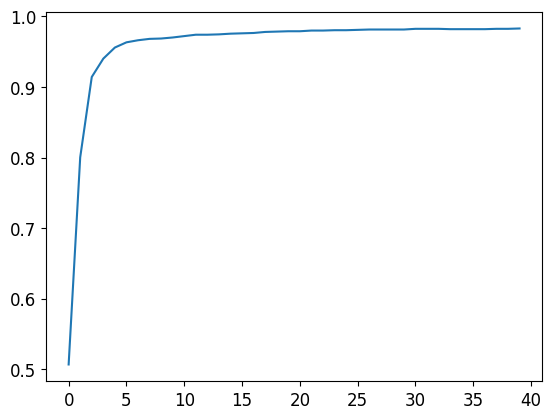

In [1009]:
# plotting the accuracy training, the x-axis is the epoch number and the y-axis is the accuracy
plt.plot(L(learn.recorder.values).itemgot(2))

In [1011]:
# let's try more layers with a pre trained model
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.10/dist-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.080864,0.011374,0.996565,00:09


See what we can do with fewer epochs and more layers ? That's impressive !